**Low-Resolution Module**
using Super-Resolution CNN Model

importing Libraries

In [ ]:
import sys
import keras
import cv2
import numpy as np
import matplotlib
import skimage
from keras.models import Sequential
from keras.layers import Conv2D, Input
from tensorflow.keras.optimizers import SGD,Adam 
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import math
import os

Base Functions

In [ ]:
#  For peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    
    rmse = math.sqrt(np.mean(diff ** 2.))
    
   
    return 20 * math.log10(255. / rmse)


# define function that calls the quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores

In [ ]:
#Image processing functions

def crop(image, scale):

  tempsize=image.shape
  size=tempsize[0:2]  #dropping one channel
  size=size-np.mod(size, scale)
  image = image[0:size[0], 1:size[1]]

  return image

def cutout(image, border_size):

  img = image[border_size: -border_size, border_size: -border_size]

  return img


Neural Network Model

In [ ]:
def model():
  SRCNN=Sequential() #Model Type

  #First Layer
  SRCNN.add(Conv2D(filters=128, kernel_size=(9,9),  activation="relu", padding="valid", use_bias=True, input_shape=(None, None, 1)))


  #Second Layer
  SRCNN.add(Conv2D(filters=64, kernel_size=(3,3),  activation="relu", padding="same", use_bias=True))

    #Third Layer
  SRCNN.add(Conv2D(filters=1, kernel_size=(5,5),  activation="relu", padding="valid", use_bias=True))

  #Optimizer
  adam = Adam(lr=0.004)

  #Compiling the model
  SRCNN.compile(optimizer=adam, loss='L1', metrics=['mean_squared_error'])

  return SRCNN

In [ ]:
path=f'/content/drive/MyDrive/FYP/LR_Dataset'   #Test Image
for file in os.listdir(path):  
  # open the file
  img = cv2.imread(path+'/'+file)
  factor=2

  # find old and new image dimensions
  h, w, _ = img.shape
  new_height = int(h / factor)
  new_width = int(w / factor)

  # resize the image - down
  img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)

  # resize the image - up
  img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)

  # save the image
  print('Saving {}'.format(file))
  cv2.imwrite('/content/LR/{}'.format(file), img)

Saving test2.1.jpg
Saving test2.2.jpg
Saving 11.png
Saving 5.png
Saving classroom3.jpg
Saving 18.png
Saving 17.png


Prediction Function

In [ ]:
#Prediction Function

def predict(image_path):
  srcnn=model()
  srcnn.load_weights('/content/drive/MyDrive/FYP/Weights/SR_trainedWeights.h5')

  #load degraded and reference images
  path, file =os.path.split(image_path)
  lr = cv2.imread(f"/content/LR/17.png")
  original = cv2.imread(image_path)


  #Convert Image into YCrCb
  temp = cv2.cvtColor(lr, cv2.COLOR_BGR2YCrCb)

  #Image slicing
  Y = np.zeros((1, temp.shape[0],temp.shape[1], 1), dtype=float)
  Y[0, :, :, 0] = lr[:,:,0].astype(float) / 255

  #Super-Resolution
  pre = srcnn.predict(Y, batch_size=1)

  #Post process Output
  pre *= 255
  pre[pre[:]>255] = 255
  pre[pre[:]<0] = 0

  pre=pre.astype(np.uint8)

  #Copy Y channel back to image and convert to BGR

  temp=cutout(temp,6)
  temp[:,:,0] = pre[0,:,:,0]
  output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)

  #removing borders
  original = cutout(original.astype(np.uint8),6)
  lr = cutout(lr.astype(np.uint8), 6)

  #Image quality Calculations
  scores=[]
  scores.append(compare_images(lr,original))
  scores.append(compare_images(output,original))

  return lr, output, scores


Results for Improved Reolution

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Low Resolution-Image: 
PSNR:30.923451205076585
SSIM:0.9696617472072959
Super Resolution-Image: 
PSNR:26.880771423855908
SSIM:0.9722476615597987


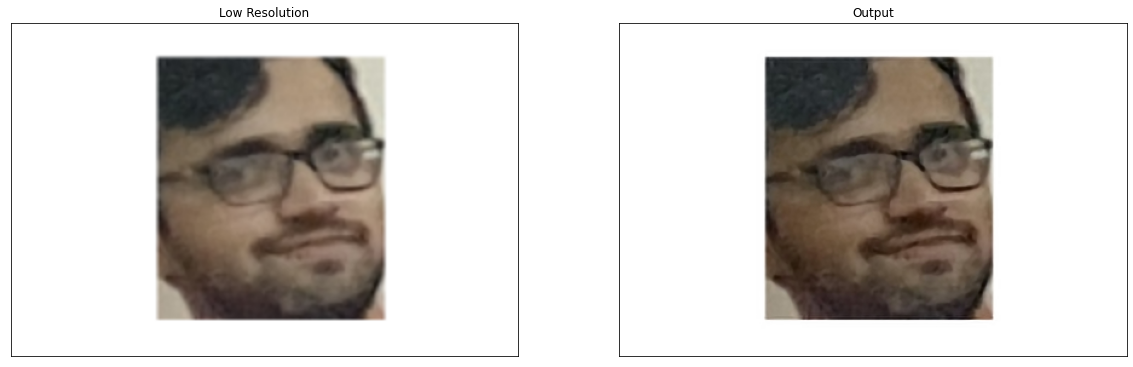

In [ ]:
degraded, output, scores = predict(f"/content/drive/MyDrive/FYP/LR_Dataset/17.png")

print("Low Resolution-Image: \nPSNR:{}\nSSIM:{}".format(scores[0][0], scores[0][1]))
print("Super Resolution-Image: \nPSNR:{}\nSSIM:{}".format(scores[1][0], scores[1][1]))


#display images
fig, axs = plt.subplots(1,2,figsize=(20,8))
#axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)) 
#axs[0].set_title("Original")
axs[0].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB)) 
axs[0].set_title("Low Resolution")
axs[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB)) 
axs[1].set_title("Output")

for ax in axs:
  ax.set_xticks([])
  ax.set_yticks([])